In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pickle

import utils, augment, models

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [5]:
TRAIN = 'data/train.tfrecords'
VAL = 'data/val.tfrecords'

train_path = "train.txt"
validation_path = "val.txt"
images_path = "images/Resized_original_1024/"
labels_path = "Segmentations/SegmentationClassPNG/"

In [7]:
## write train dataset
with tf.io.TFRecordWriter(TRAIN) as writer:
    with open(train_path) as file:
        filenames = [s.rstrip('\n') for s in file.readlines()]
    for name in filenames:
        image = utils.get_image(images_path+name+'.jpg')
        label = utils.get_label_png(labels_path+name+'.png')
        writer.write(utils.get_example(image, label).SerializeToString())

In [8]:
## write validation dataset
with tf.io.TFRecordWriter(VAL) as writer:
    ## write .mat files
    with open(validation_path) as file:
        filenames = [s.rstrip('\n') for s in file.readlines()]
    for name in filenames:
        image = utils.get_image(images_path+name+'.jpg')
        label = utils.get_label_png(labels_path+name+'.png')
        writer.write(utils.get_example(image, label).SerializeToString())

In [9]:
## read data from tfrecords files
def map_func(example):
    image, label = utils.parse_example(example)
    #return image, label
    return augment.resize_with_pad(image,label) # no dataset augmentation

train_dataset = tf.data.TFRecordDataset('data/train.tfrecords').map(map_func)
val_dataset = tf.data.TFRecordDataset('data/val.tfrecords').map(map_func)

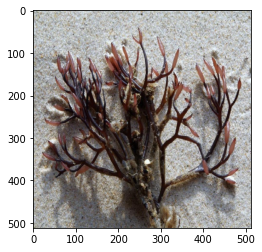

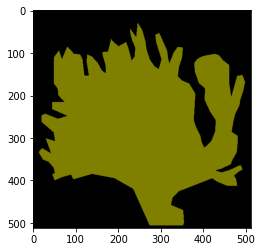

In [10]:
## check data
for X, y in train_dataset.shuffle(20).take(1):
    plt.figure()
    plt.imshow(X)
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y))
    plt.show()

In [11]:
## VGG16 base model
base_model = models.vgg16(l2=1e-6, dropout=0.2)

In [12]:
## Load ImageNet weights
## https://keras.io/api/applications/
vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')
weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)
del weight_list

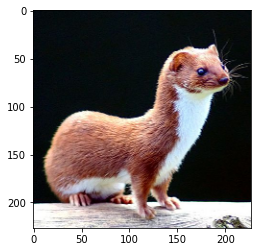

Top three guesses with probabilities:
weasel (p=0.791)
mink (p=0.103)
polecat, fitch, foulmart, foumart, Mustela putorius (p=0.103)


In [13]:
## Test base model
from class_names.imagenet import class_names

img = utils.get_image('assets/laska.png')
plt.figure()
plt.imshow(img)
plt.show()

print('Top three guesses with probabilities:')
probs = base_model.predict(img[None])[0, 3, 3] # pick the central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(3):
    c = pred[i]
    print("{0:s} (p={1:.3f})".format(class_names[c], probs[c]))

In [14]:
## FCN32
fcn32 = models.fcn32(base_model, l2=1e-6)
# ## freeze lower layers for fine-tuning
# fcn32.get_layer('block1_conv1').trainable=False
# fcn32.get_layer('block1_conv2').trainable=False
# fcn32.get_layer('block2_conv1').trainable=False
# fcn32.get_layer('block2_conv2').trainable=False
# fcn32.get_layer('block3_conv1').trainable=False
# fcn32.get_layer('block3_conv2').trainable=False
# fcn32.get_layer('block3_conv3').trainable=False
# fcn32.get_layer('block4_conv1').trainable=False
# fcn32.get_layer('block4_conv2').trainable=False
# fcn32.get_layer('block4_conv3').trainable=False
## freeze upsample layer
fcn32.get_layer('fcn32').trainable=False

In [15]:
## Load model
model = fcn32
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, None, 3)]   0         
                                                                 
 preprocessing (Lambda)      (None, None, None, 3)     0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   1475

In [16]:
## compile
opt = keras.optimizers.Adam(learning_rate=1e-4)
loss = models.crossentropy
metrics = [loss,
           models.pixelacc,
           models.MyMeanIoU(num_classes=5, name='meanIoU')]
model.compile(optimizer=opt, loss=loss, metrics=metrics)

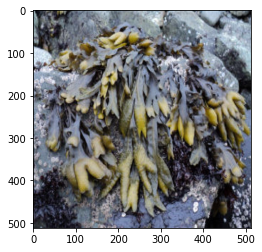

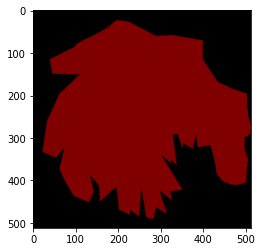

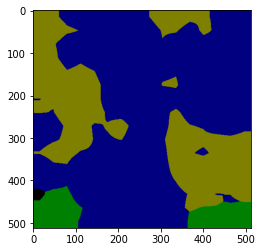

In [17]:
for X, y in train_dataset.shuffle(1000).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y[0]))
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(utils.onehot_to_label(model(X)[0])))
    plt.show()

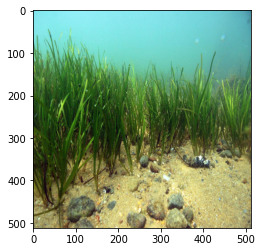

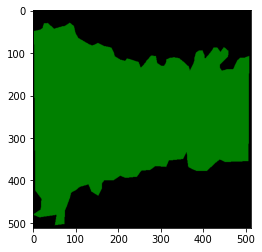

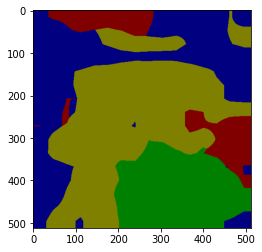

1/1 [==============================] - 2s 2s/step - loss: 2.3410 - crossentropy: 2.3363 - pixelacc: 0.0354 - meanIoU: 0.0096


In [18]:
## test model
for X, y in val_dataset.shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y[0]))
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(utils.onehot_to_label(model(X)[0])))
    plt.show()
    
    model.evaluate(X, y)

In [19]:
## check running GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [20]:
## training and validation datasets
train = train_dataset.shuffle(1000).batch(16)
val = val_dataset.shuffle(1000).batch(16)

In [21]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
4/4 [==============================] - 38s 7s/step - loss: 2.5143 - crossentropy: 2.4455 - pixelacc: 0.2612 - meanIoU: 0.1025 - val_loss: 1.1648 - val_crossentropy: 1.1577 - val_pixelacc: 0.5138 - val_meanIoU: 0.2569
Epoch 2/10
4/4 [==============================] - 6s 1s/step - loss: 1.2110 - crossentropy: 1.1972 - pixelacc: 0.4862 - meanIoU: 0.2538 - val_loss: 1.0342 - val_crossentropy: 1.0275 - val_pixelacc: 0.5673 - val_meanIoU: 0.3176
Epoch 3/10
4/4 [==============================] - 6s 1s/step - loss: 0.9440 - crossentropy: 0.9297 - pixelacc: 0.6132 - meanIoU: 0.3614 - val_loss: 0.5926 - val_crossentropy: 0.5865 - val_pixelacc: 0.7801 - val_meanIoU: 0.5143
Epoch 4/10
4/4 [==============================] - 6s 1s/step - loss: 0.6365 - crossentropy: 0.6412 - pixelacc: 0.7537 - meanIoU: 0.5218 - val_loss: 0.5799 - val_crossentropy: 0.5766 - val_pixelacc: 0.7814 - val_meanIoU: 0.5208
Epoch 5/10
4/4 [==============================] - 6s 1s/step - loss: 0.6013 - crossentropy:

In [25]:
model.save_weights('/content/weights/fcn32_5.h5')

with open('/content/Keras-FCN/logs/fcn32_10', 'wb') as f:
    pickle.dump(history.history, f)

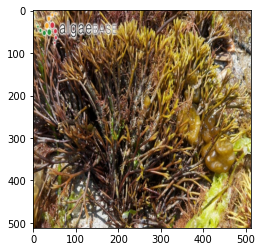

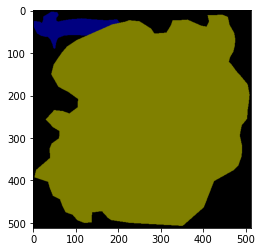

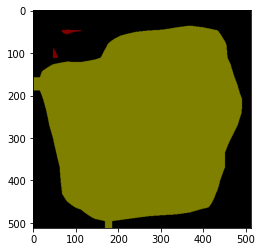

1/1 [==============================] - 0s 78ms/step - loss: 0.4485 - crossentropy: 0.4438 - pixelacc: 0.8355 - meanIoU: 0.3481


In [24]:
## test model
for X, y in val_dataset.shuffle(100).batch(1).take(1):
    plt.figure()
    plt.imshow(X[0])
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(y[0]))
    plt.show()
    
    plt.figure()
    plt.imshow(utils.label_to_image(utils.onehot_to_label(model(X)[0])))
    plt.show()
    
    model.evaluate(X, y)

In [26]:
with open('logs/fcn32_10', 'rb') as f:
    h2 = pickle.load(f)

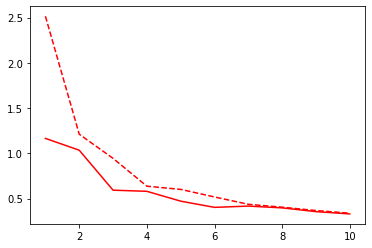

In [29]:
plt.plot(range(1,11), h2['val_loss'], '-', color='red', label='FCN32 validation loss')
plt.plot(range(1,11), h2['loss'], '--', color='red', label='FCN32 training loss')

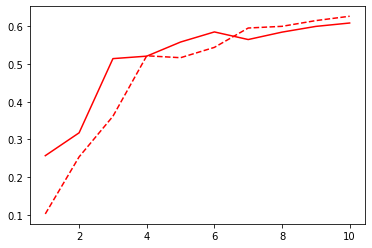

In [30]:
plt.plot(range(1,11), h2['val_meanIoU'], '-', color='red', label='FCN32 validation meanIoU')
plt.plot(range(1,11), h2['meanIoU'], '--', color='red', label='FCN32 training meanIoU')

In [32]:
print('fcn32 pixel acc: {0:.3f}'.format(h2['val_pixelacc'][-1]))

fcn32 pixel acc: 0.853


In [33]:
print('fcn32 val meanIoU: {0:.3f}'.format(h2['val_meanIoU'][-1]))

fcn32 val meanIoU: 0.609
